## Data download
We download TCGA-LUAD and TCGA-LUSC from GDC portal using the gdc-client software.

In [ ]:
%%bash

mkdir luad
mkdir lusc

gdc-client download -d luad -m luad.mani.txt
gdc-client download -d lusc -m lusc.mani.txt

## Data transformation
We create a data matrix and labels for our decision tree.

In [4]:
import glob
import gzip

def getMatrix(root):
    files = glob.glob(root + "/*/*.gz")
    matrix = list()
    for i in files:
        expfile = gzip.open(i)
        matrix.append([])
        for lines in expfile:
            expression = lines.decode("utf-8").rstrip().split()[1]
            matrix[-1].append(float(expression))
        expfile.close()
    return matrix

luadmatrix = getMatrix("luad")
luscmatrix = getMatrix("lusc")

In [37]:
data = luadmatrix + luscmatrix
category = ['luad'] * len(luadmatrix) + ['lusc'] * len(luscmatrix)

We also create a gene list.

In [14]:
genenames = list()
expfile = gzip.open("lusc/5dd30ba1-2051-42f6-8fb4-3c49c93b8bf1/6976923e-a954-4ba0-9d1d-f97d7373ba48.FPKM.txt.gz")
for lines in expfile:
    gname = lines.decode("utf-8").split()[0]
    genenames.append(gname)
expfile.close()

## Train decision tree
Because it is for demonstration purposes, we do not create test and validation data, just use everything for training.

In [17]:
from sklearn import tree
dectree = tree.DecisionTreeClassifier(max_depth = 5)
dectree = dectree.fit(data, category)

Create some nice graphics and save the results.

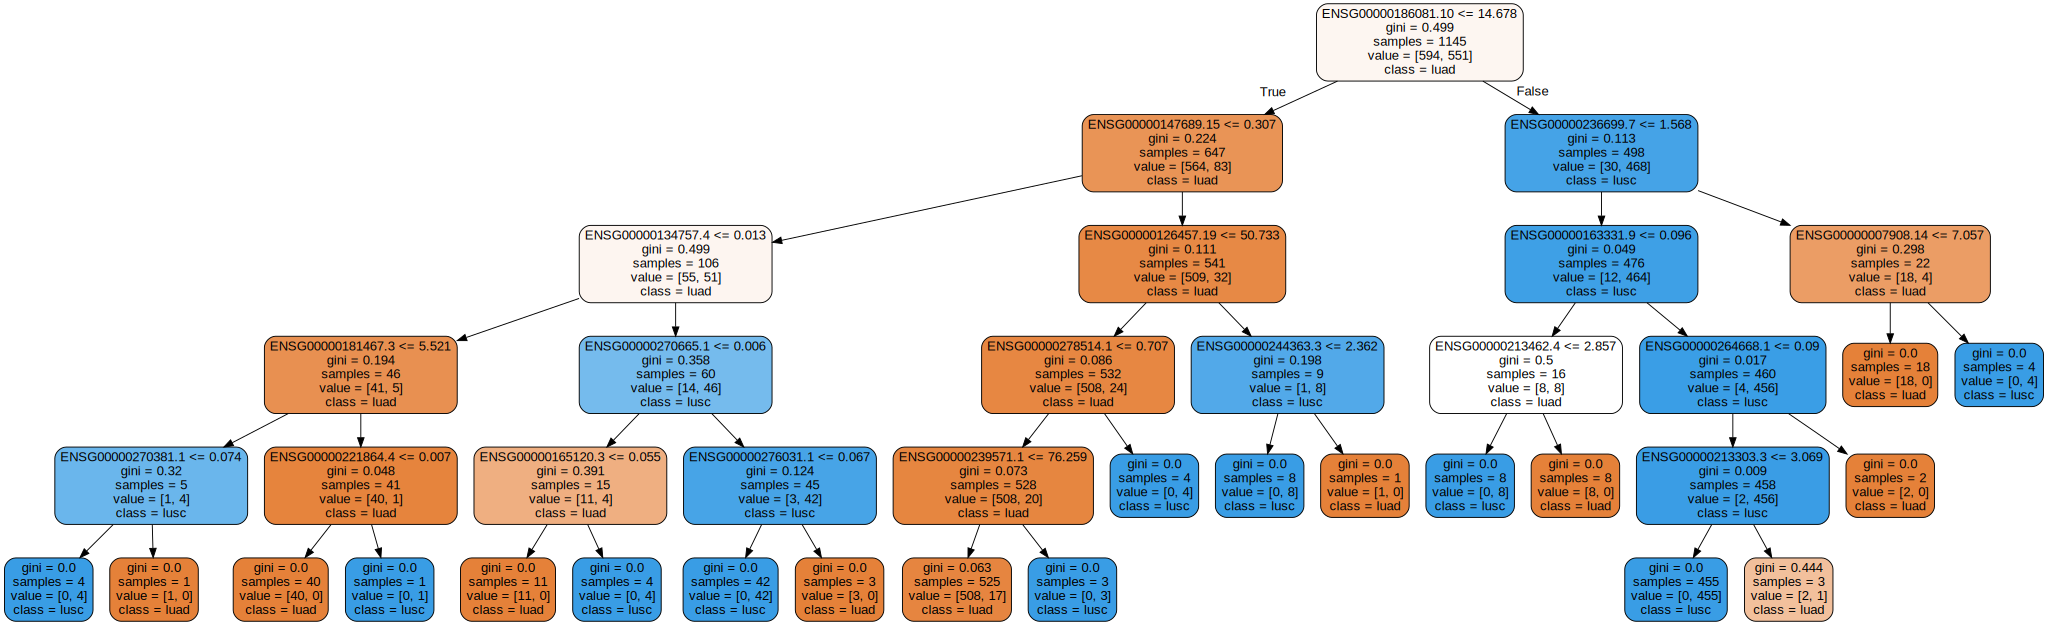

In [33]:
import graphviz
dot = tree.export_graphviz(dectree, out_file=None, feature_names=genenames, class_names=['luad', 'lusc'], rounded=True, filled=True)
graph = graphviz.Source(dot, format='png')
graph.render("output1")
graph

We manually check the numbers of the categories in a randomly choosen node.

In [31]:
luadcount = 0
lusccount = 0
for i in range(len(data)):
    if data[i][genenames.index("ENSG00000186081.10")] > 14.678 and data[i][genenames.index("ENSG00000236699.7")] <= 1.568:
        if category[i] == "luad":
            luadcount += 1
        else:
            lusccount += 1
print("luad: %d   lusc: %d" % (luadcount, lusccount))

luad: 12   lusc: 464


Demonstrating decision tree instability.

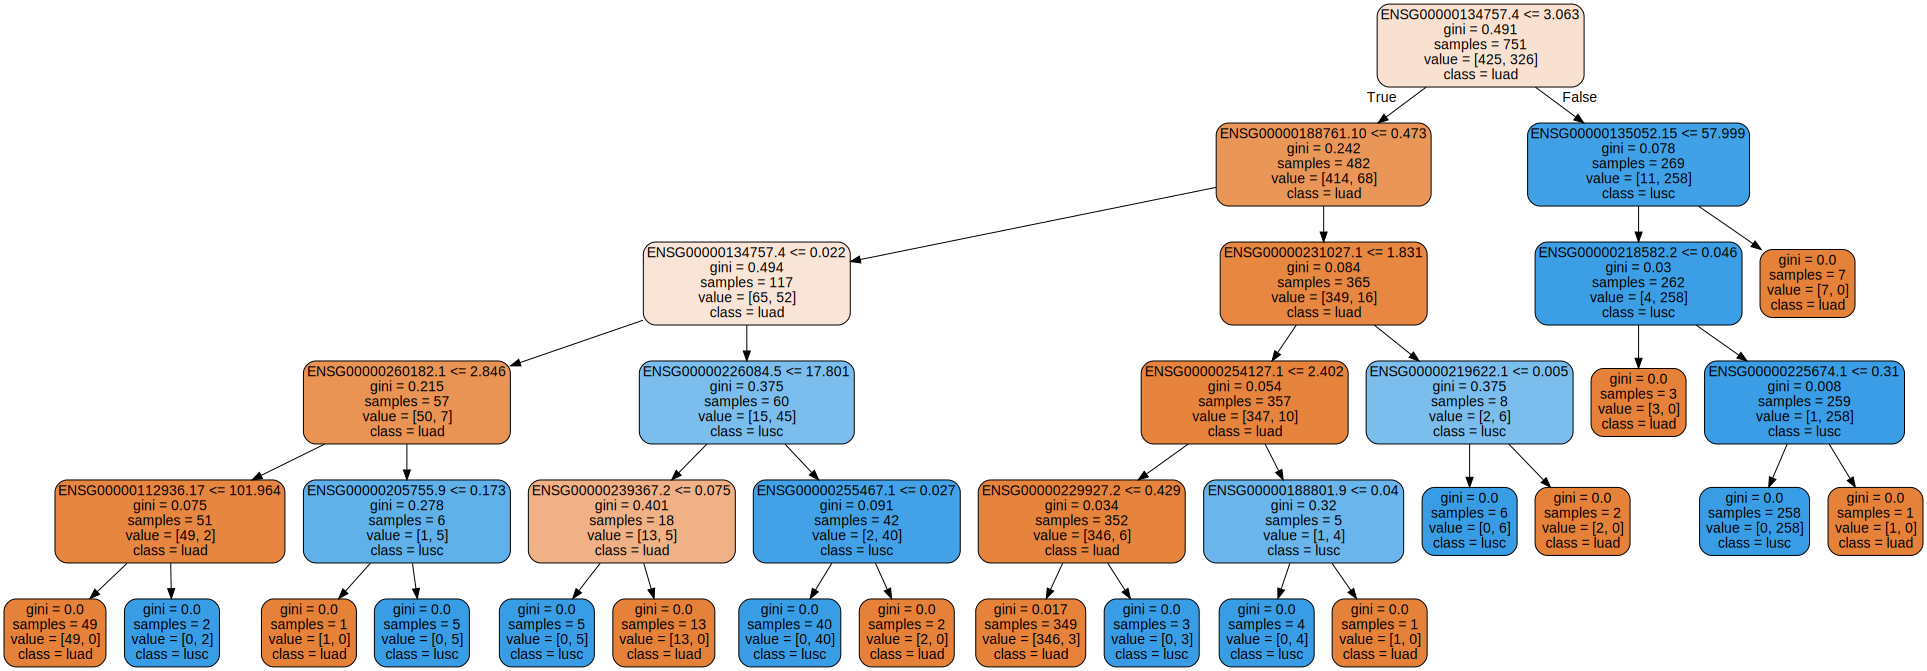

In [35]:
subsetdata = list()
subsetcateg = list()
for i in range(len(data)):
    average = sum(data[i]) / float(len(data[i]))
    if average > 5.0:
        subsetdata.append(data[i])
        subsetcateg.append(category[i])

dectree2 = tree.DecisionTreeClassifier(max_depth = 5)
dectree2 = dectree.fit(subsetdata, subsetcateg)
dot = tree.export_graphviz(dectree2, out_file=None, feature_names=genenames, class_names=['luad', 'lusc'], rounded=True, filled=True)
graph = graphviz.Source(dot, format='png')
graph.render("output2")
graph

In [36]:
len(subsetdata)

751